In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# One-hot encode labels
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [3]:
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train_cat))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

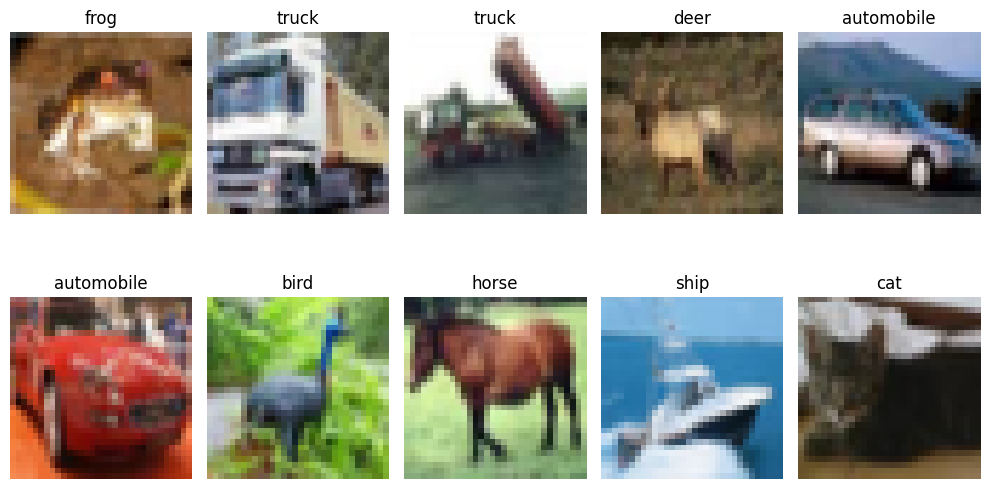

In [4]:
plt.figure(figsize=(10, 6))
for i in range(10):
    img = x_train[i]
    label = class_names[y_train[i][0]]
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # freeze base layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 60s 31ms/step - accuracy: 0.6969 - loss: 0.8905 - val_accuracy: 0.7888 - val_loss: 0.6033
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 28ms/step - accuracy: 0.7944 - loss: 0.5950 - val_accuracy: 0.8161 - val_loss: 0.5328
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.8127 - loss: 0.5375 - val_accuracy: 0.8227 - val_loss: 0.5160
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 43s 27ms/step - accuracy: 0.8228 - loss: 0.5127 - val_accuracy: 0.8199 - val_loss: 0.5280
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.8331 - loss: 0.4828 - val_accuracy: 0.8275 - val_loss: 0.5217
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 24ms/step - accuracy: 0.8415 - loss: 0.4545 - val_accuracy: 0.8237 - val_loss: 0.5170


In [8]:
loss, acc = model.evaluate(val_ds)
print(f"Test Accuracy: {acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8205 - loss: 0.5253
Test Accuracy: 0.8227


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step
              precision    recall  f1-score   support

    airplane       0.87      0.79      0.83      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.77      0.78      0.77      1000
         cat       0.64      0.75      0.69      1000
        deer       0.78      0.79      0.78      1000
         dog       0.82      0.71      0.76      1000
        frog       0.83      0.88      0.85      1000
       horse       0.85      0.87      0.86      1000
        ship       0.88      0.89      0.88      1000
       truck       0.91      0.88      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



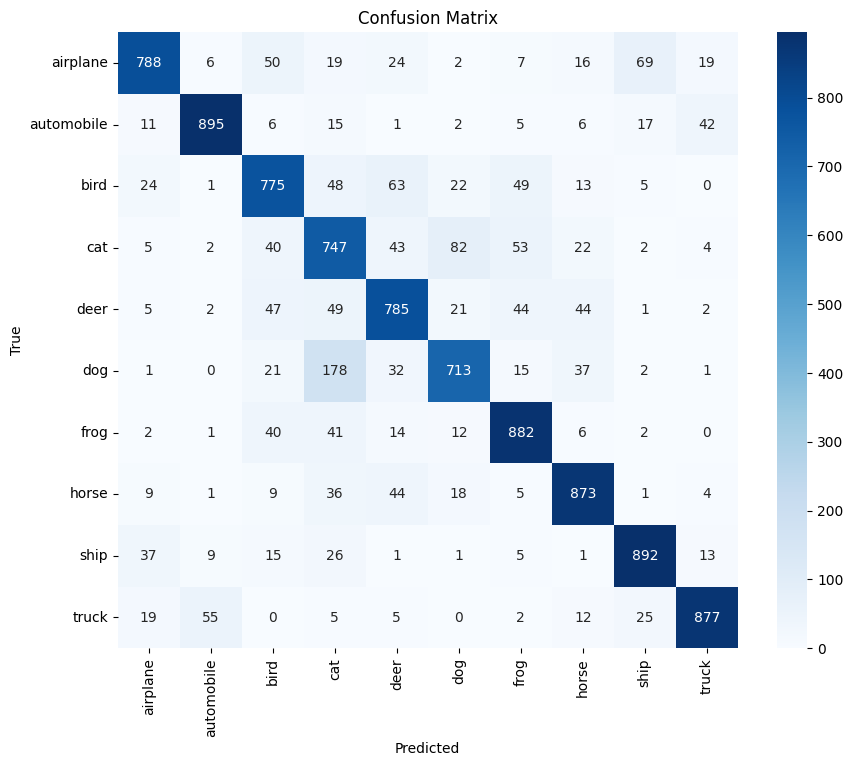

In [9]:
# Predict
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [10]:
model.save('cifar10_transfer_model.keras')

In [11]:
# Unfreeze from layer 100 onwards (out of ~154)
UNFREEZE_FROM = 100

# Unfreeze the base model
base_model.trainable = True

# Freeze all layers before `UNFREEZE_FROM`
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= UNFREEZE_FROM


In [12]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 94s 45ms/step - accuracy: 0.7355 - loss: 0.8116 - val_accuracy: 0.8535 - val_loss: 0.4406
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.8378 - loss: 0.4786 - val_accuracy: 0.8690 - val_loss: 0.3912
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8681 - loss: 0.3923 - val_accuracy: 0.8792 - val_loss: 0.3687
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.8877 - loss: 0.3271 - val_accuracy: 0.8871 - val_loss: 0.3491
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9013 - loss: 0.2886 - val_accuracy: 0.8900 - val_loss: 0.3376
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9161 - loss: 0.2464 - val_accuracy: 0.8948 - val_loss: 0.3317
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - accuracy: 0.9283 - loss: 0.2126 - val_accuracy: 0.8981 - val_loss: 0.3329
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 50s 32ms/step - accuracy: 0.9331 -

In [14]:
model.save('cifar10_transfer_model.keras')

In [1]:
pip install black

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.5 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 1.4 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pylint

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 522 kB 560 kB/s eta 0:00:01
     |████████████████████████████████| 94 kB 815 kB/s eta 0:00:01
     |████████████████████████████████| 119 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 275 kB 685 kB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install ruff

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 10.4 MB 1.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
